In [2]:
import gspread
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from time import time, gmtime, sleep
import sys
sys.path.append("/home/jovyan/HSE-Bioinformatics")
sys.path.append("/home/jovyan/diploma_scripts/scripts")
from bio import *
import dcona_runs
import dcona
from tqdm.auto import tqdm; tqdm.pandas()
import telegram_send
import multiprocessing

In [3]:
SHARED_PATH = Path('/home/jovyan/shared')
TCGA_PATH = SHARED_PATH / 'TCGA_data'
OUTPUT_PATH = SHARED_PATH / 'narek/outputs'
BRCA_DATA = SHARED_PATH / 'narek/Diplom2/data_BRCA'

In [4]:
annotation = rt(BRCA_DATA/'annotation.tsv')

In [30]:
raw_rna22_inter = rt(SHARED_PATH/'miRNA_predictions_BRCA/RNA22.tsv', i=None)
raw_ts_inter = rt(SHARED_PATH/'miRNA_predictions_BRCA/TargetScan.tsv', i=None)

# Эксперимент 1
## BRCA, gene_expressions, Normal, делим по концентрации major AGO2 (ENST00000220592.9)

In [5]:
TCGA_STUDY = 'TCGA-BRCA'
iso_type = "pan_cancer_exclusive_log2_FPM_DESeq2"

In [6]:
gene_exp = rt(f"{TCGA_PATH}/{TCGA_STUDY}/RSEM_transcript_pan_cancer_log2_FPKM_DESeq2.tsv")

In [64]:
normal_ids = annotation.loc[annotation['Sample type'] == 'Normal'].index.to_numpy()
brca_normal_exp_all = dcona_runs.extract_samples(gene_exp, normal_ids, additional_columns=['gene symbol'])
brca_normal_exp = dcona_runs.filter_by_median(brca_normal_exp_all, additional_columns=['gene symbol'], cutoff=95)

In [80]:
brca_normal_exp = dcona_runs.remove_transcript_version(brca_normal_exp)
brca_normal_exp

,gene symbol,TCGA-A7-A0CE-11,TCGA-A7-A0D9-11,TCGA-A7-A0DB-11,TCGA-A7-A0DC-11,TCGA-A7-A13E-11,TCGA-A7-A13F-11,TCGA-A7-A13G-11,TCGA-AC-A23H-11,TCGA-AC-A2FB-11,...,TCGA-E9-A1NG-11,TCGA-E9-A1R7-11,TCGA-E9-A1RB-11,TCGA-E9-A1RC-11,TCGA-E9-A1RD-11,TCGA-E9-A1RF-11,TCGA-E9-A1RH-11,TCGA-E9-A1RI-11,TCGA-GI-A2C8-11,TCGA-GI-A2C9-11
transcript,,,,,,,,,,,,,,,,,,,,,
ENST00000361624,MT-CO1,11.683142,13.763776,13.955086,12.461920,13.055692,13.383734,13.948649,13.657764,12.426773,...,12.742827,13.189445,13.347080,13.496385,12.952189,13.809001,13.988268,13.715742,15.525530,11.950340
ENST00000362079,MT-CO3,11.723500,13.494072,13.318108,12.118561,12.756507,13.236324,13.624148,13.482154,12.410751,...,12.641316,12.796368,12.959797,13.401570,12.877875,13.583294,13.842554,13.292753,14.841225,11.706179
ENST00000361381,MT-ND4,11.378070,13.869295,13.429452,12.326472,12.750859,12.540766,13.448813,13.218629,12.041379,...,12.574079,13.273563,13.261315,13.451816,13.028606,13.905221,13.880101,13.360398,14.406792,11.222201
ENST00000361899,MT-ATP6,11.418196,13.592460,13.341506,12.086067,12.530639,12.583007,13.389866,13.207479,11.949544,...,12.511535,13.027835,13.116079,13.564054,12.869575,13.830973,13.830454,13.562028,14.494436,11.405175
ENST00000331523,EEF1A1,12.548791,11.675052,12.187943,11.401340,11.374907,12.072876,11.662944,12.989273,12.409620,...,11.530344,11.401664,12.270976,11.560378,11.763965,11.975500,11.756037,12.028122,9.768267,11.948984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENST00000409649,IMP4,1.477521,1.634497,2.652178,0.789372,0.582040,0.685613,0.595984,0.000000,1.354100,...,2.226318,1.489910,1.637914,2.365116,1.015647,0.000000,1.603908,0.000000,3.775199,1.993406
ENST00000483428,RBM18,1.043232,2.468417,2.251502,0.924410,1.681950,1.325159,1.381876,0.802508,0.757670,...,1.446022,1.125187,1.681316,1.634556,1.348730,1.907718,0.688543,0.721023,2.998281,1.027648
ENST00000514013,SH3D19,0.000000,3.598340,3.422335,2.281380,2.903486,2.086797,2.442223,0.841393,1.621217,...,3.341023,3.805915,3.248336,3.601757,3.068998,3.733268,2.896698,4.596519,0.488294,1.031260


### Делим образцы по экспрессии AGO2

(1.221, 1.607]    11
(1.607, 1.723]    10
(1.723, 1.809]    10
(1.809, 1.872]    11
(1.872, 1.929]    10
(1.929, 1.985]    10
(1.985, 2.065]    11
(2.065, 2.122]    10
(2.122, 2.258]    10
(2.258, 3.012]    11
Name: ENST00000220592, dtype: int64


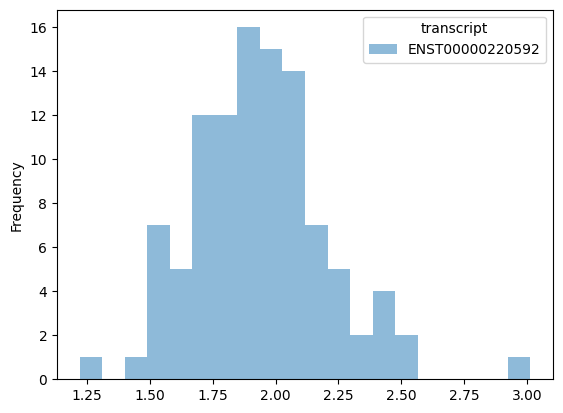

In [81]:
cutter = dcona_runs.CuttingSamples(brca_normal_exp, extra_columns=['gene symbol'])
cutter.cut('ENST00000220592')

In [82]:
cutter.extract_samples(left_num=3, right_num=3)

,Sample,Group
0,TCGA-A7-A0CE-11,Low_expr
1,TCGA-A7-A13G-11,Low_expr
2,TCGA-AC-A2FM-11,Low_expr
3,TCGA-BH-A0AY-11,Low_expr
4,TCGA-BH-A0AZ-11,Low_expr
...,...,...
57,TCGA-E9-A1RB-11,High_expr
58,TCGA-E9-A1RF-11,High_expr
59,TCGA-E9-A1RI-11,High_expr
60,TCGA-GI-A2C8-11,High_expr


In [83]:
cutter.save_annotation("AGO2_normal")

Annotation is saved at: /home/jovyan/shared/narek/outputs/sample_cuts/AGO2_normal_ENST00000220592_62_samples.csv


In [84]:
descr = rc(SHARED_PATH/'narek/outputs/sample_cuts/AGO2_normal_ENST00000220592_62_samples.csv')
descr

,Sample,Group
0,TCGA-A7-A0CE-11,Low_expr
1,TCGA-A7-A13G-11,Low_expr
2,TCGA-AC-A2FM-11,Low_expr
3,TCGA-BH-A0AY-11,Low_expr
4,TCGA-BH-A0AZ-11,Low_expr
...,...,...
57,TCGA-E9-A1RB-11,High_expr
58,TCGA-E9-A1RF-11,High_expr
59,TCGA-E9-A1RI-11,High_expr
60,TCGA-GI-A2C8-11,High_expr


In [21]:
# TCGA_STUDY = 'TCGA-COAD'
TCGA_STUDY = 'TCGA-BRCA'
mirna = rt(f"{TCGA_PATH}/{TCGA_STUDY}/isoMiRmap_{iso_type}.tsv")

In [11]:
mirna_5prime = dcona_runs.isomir_groupby_5prime(mirna)
mirna_5prime = dcona_runs.filter_by_median(mirna_5prime, additional_columns=['median'], cutoff=99)

In [12]:
mirna_5prime

,TCGA-EW-A1PA-01,TCGA-BH-A208-01,TCGA-BH-A8G0-01,TCGA-LD-A7W6-01,TCGA-AC-A2FF-01,TCGA-LD-A7W5-01,TCGA-GM-A5PX-01,TCGA-D8-A27V-01,TCGA-AR-A2LO-01,TCGA-A7-A26E-01,...,TCGA-BH-A0H9-01,TCGA-BH-A0E0-01,TCGA-AN-A0AL-01,TCGA-A8-A07U-01,TCGA-A8-A07O-01,TCGA-A8-A09X-01,TCGA-BH-A0HY-01,TCGA-A8-A06Z-01,TCGA-A8-A07B-01,TCGA-A8-A090-01
mature,,,,,,,,,,,,,,,,,,,,,
hsa-miR-21-5p|0,17.834160,17.778060,18.258493,17.653264,17.736419,18.129305,18.366684,17.645363,18.783243,17.893510,...,17.826773,16.392713,16.611989,17.626352,17.767732,17.464629,18.241695,16.464387,17.167547,17.880802
hsa-miR-22-3p|0,16.102813,16.451833,16.371821,15.300919,16.139831,15.343830,16.575783,15.479227,15.973814,16.366988,...,15.901143,15.207893,14.814891,15.935313,15.217590,15.573884,17.093650,15.050739,15.520004,15.575681
hsa-miR-143-3p|0,15.739252,16.141910,16.784900,16.013658,16.852844,15.382058,17.493517,15.240405,18.094054,15.891257,...,16.901354,15.082281,13.914520,13.527286,13.725267,15.154154,15.982966,15.106560,15.409328,16.236813
hsa-miR-10b-5p|0,15.335262,16.104883,16.782479,16.051779,16.760878,16.000206,16.312052,15.427688,15.592367,15.217429,...,15.579090,14.662714,14.112147,15.342689,14.596647,15.101251,15.649630,14.308652,16.499005,14.972693
hsa-miR-148a-3p|0,14.802242,16.875491,14.812105,15.233364,14.931509,13.676712,15.714938,15.443221,14.254993,14.596151,...,15.035196,15.108188,17.043972,16.661283,14.308547,16.974628,15.292870,15.740604,15.496226,16.161425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hsa-miR-15a-5p|0,7.166398,7.377831,6.361704,6.854712,6.219740,6.326465,6.760974,5.710572,7.012657,6.995020,...,6.689875,6.057905,7.071934,7.074007,7.439839,6.785689,7.852538,5.660824,6.151199,5.843333
hsa-miR-361-3p|0,8.025992,6.553359,6.576088,7.131325,6.982720,7.555192,7.043555,6.082184,7.135521,6.110146,...,6.150011,5.746030,5.672334,6.523132,5.320426,6.725370,5.847179,5.553449,3.855520,5.065264
hsa-miR-629-5p|0,7.725800,6.419275,5.991480,6.415165,5.737228,6.529397,6.705594,7.099178,6.076137,6.751419,...,8.028173,8.808188,6.332710,6.617547,7.858376,7.212181,7.569753,5.760758,5.589869,6.080470


In [13]:
brca_normal_united = pd.concat(tcga_match_samples(brca_normal_exp.drop('gene symbol', axis=1), mirna_5prime))
brca_normal_united

,TCGA-A7-A0CE-11,TCGA-A7-A0D9-11,TCGA-A7-A0DB-11,TCGA-A7-A0DC-11,TCGA-A7-A13E-11,TCGA-A7-A13F-11,TCGA-A7-A13G-11,TCGA-AC-A23H-11,TCGA-AC-A2FB-11,TCGA-AC-A2FM-11,...,TCGA-E9-A1NG-11,TCGA-E9-A1R7-11,TCGA-E9-A1RB-11,TCGA-E9-A1RC-11,TCGA-E9-A1RD-11,TCGA-E9-A1RF-11,TCGA-E9-A1RH-11,TCGA-E9-A1RI-11,TCGA-GI-A2C8-11,TCGA-GI-A2C9-11
ENST00000361624,11.683142,13.763776,13.955086,12.461920,13.055692,13.383734,13.948649,13.657764,12.426773,11.864437,...,12.742827,13.189445,13.347080,13.496385,12.952189,13.809001,13.988268,13.715742,15.525530,11.950340
ENST00000362079,11.723500,13.494072,13.318108,12.118561,12.756507,13.236324,13.624148,13.482154,12.410751,12.148143,...,12.641316,12.796368,12.959797,13.401570,12.877875,13.583294,13.842554,13.292753,14.841225,11.706179
ENST00000361381,11.378070,13.869295,13.429452,12.326472,12.750859,12.540766,13.448813,13.218629,12.041379,11.330737,...,12.574079,13.273563,13.261315,13.451816,13.028606,13.905221,13.880101,13.360398,14.406792,11.222201
ENST00000361899,11.418196,13.592460,13.341506,12.086067,12.530639,12.583007,13.389866,13.207479,11.949544,11.593680,...,12.511535,13.027835,13.116079,13.564054,12.869575,13.830973,13.830454,13.562028,14.494436,11.405175
ENST00000331523,12.548791,11.675052,12.187943,11.401340,11.374907,12.072876,11.662944,12.989273,12.409620,12.888889,...,11.530344,11.401664,12.270976,11.560378,11.763965,11.975500,11.756037,12.028122,9.768267,11.948984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hsa-miR-15a-5p|0,5.895727,6.339012,6.480579,5.426186,6.080981,5.754868,6.317792,5.812877,5.413464,4.268096,...,6.294209,6.314035,8.360470,7.116337,6.130537,6.779237,5.874528,6.563077,7.176590,6.436036
hsa-miR-361-3p|0,6.264398,5.774354,5.886448,6.196318,6.591342,5.633978,6.694298,7.052795,7.033944,8.304044,...,6.572330,6.538046,6.574676,5.959951,7.070447,6.267463,6.729569,6.346874,5.515332,7.527448
hsa-miR-629-5p|0,6.201763,7.111106,6.500122,6.140154,6.115552,5.168004,6.252880,6.386052,6.257222,7.229507,...,5.855784,6.060490,7.178534,6.015539,6.654165,6.216653,6.115618,6.547305,5.485206,6.194690
hsa-miR-143-3p|+3,8.212872,8.490471,8.579370,8.537267,8.824963,8.519515,8.632285,7.267839,7.979258,6.653659,...,8.331069,8.695532,6.581398,8.301525,7.007626,8.007813,8.993801,8.466093,9.868566,7.698610


#### TargetScan

In [94]:
ts_inter = rt(SHARED_PATH/'miRNA_predictions_BRCA/TargetScan.tsv', i=None)
ts_inter = ts_inter[['isomir', 'transcript']].drop_duplicates()
ts_inter.columns = ['Source', 'Target']
ts_inter

,Source,Target
0,hsa-miR-126-3p|0,CDR1as
3,hsa-miR-126-5p|0,CDR1as
5,hsa-miR-141-5p|0,CDR1as
6,hsa-miR-143-3p|-1,CDR1as
7,hsa-miR-143-3p|0,CDR1as
...,...,...
1965530,hsa-miR-92a-3p|0,ENST00000610205
1965531,hsa-miR-92b-3p|0,ENST00000610205
1965532,hsa-miR-150-5p|0,ENST00000610273
1965533,hsa-miR-338-3p|0,ENST00000610273


In [117]:
brca_ts_filtered, descr_ts_filtered, interaction_ts_filtered = dcona_runs.brush_data_before_dcona(brca_normal_united, descr, ts_inter)

In [15]:
expmt = dcona_runs.Experiment(
    experiment = '1',
    cancer_type = "TCGA-BRCA",
    subtypes = ["Normal"],
    interactions_source ='TargetScan'
)

  status experiment cancer_type subtypes interactions_source ztest_args  \
1    New          1   TCGA-BRCA   Normal          TargetScan        NaN   

  ztest_start ztest_end ztest_time ztest_path  
1         NaN       NaN        NaN        NaN  


In [19]:
%%capture
expmt.run_ztest(
    ztest_kwargs = {
        'data_df': brca_ts_filtered, 
        'description_df': descr_ts_filtered, 
        'reference_group': "Low_expr",
        'experimental_group': "High_expr",
        'interaction': interaction_ts_filtered,
        'process_number': 32,
#         'repeats_number': 1000,
    },
    filename='ztest_ts.csv'
)


#### RNA22

In [95]:
rna22_inter = rt(SHARED_PATH/'miRNA_predictions_BRCA/RNA22.tsv', i=None)
rna22_inter = rna22_inter[['isomir', 'transcript']].drop_duplicates()
rna22_inter.columns = ['Source', 'Target']
rna22_inter

,Source,Target
0,hsa-let-7a-5p|0,ENST00000001146
7,hsa-let-7b-5p|0,ENST00000001146
19,hsa-let-7c-5p|0,ENST00000001146
30,hsa-let-7d-3p|0,ENST00000001146
31,hsa-let-7d-5p|0,ENST00000001146
...,...,...
2945534,hsa-miR-500a-3p|0,ENST00000633867
2945543,hsa-miR-532-5p|0,ENST00000633867
2945548,hsa-miR-9-5p|0,ENST00000633867
2945550,hsa-miR-99a-5p|0,ENST00000633867


In [15]:
brca_rna22_filtered, descr_rna22_filtered, interaction_rna22_filtered = dcona_runs.brush_data_before_dcona(brca_normal_united, descr, rna22_inter)

In [18]:
%%capture
expmt2 = dcona_runs.Experiment(
    experiment = '1',
    cancer_type = "TCGA-BRCA",
    subtypes = ["Normal"],
    interactions_source ='RNA22'
)

In [ ]:
%%capture
expmt2.run_ztest(
    ztest_kwargs = {
        'data_df': brca_rna22_filtered, 
        'description_df': descr_rna22_filtered, 
        'reference_group': "Low_expr",
        'experimental_group': "High_expr",
        'interaction': interaction_rna22_filtered,
        'process_number': 32,
#         'repeats_number': 1000,
    },
    filename='ztest_rna22.csv'
)

### Результаты

In [1]:
def adjust_permute(df):
    df = df.copy()
    df['AdjPermutePvalue'] = df['PermutePvalue'] / round(df.rank(axis=0)["PermutePvalue"]) * df.shape[0]
    return df.sort_values('AdjPermutePvalue')

def pvalue_cutoff(df, by: str, alpha: float = 0.05):
    return df.loc[df[by] <= alpha]

Targetscan

In [19]:
ts = rc(OUTPUT_PATH/'experiments/1/ztest_ts.csv')
ts.sort_values('PermutePvalue', inplace=True)

In [55]:
pvalue_cutoff(adjust_permute(ts), 'AdjPermutePvalue', 0.1)

,Source,Target,RefCorr,RefPvalue,ExpCorr,ExpPvalue,Statistic,Pvalue,AdjPvalue,PermutePvalue,AdjPermutePvalue


In [27]:
pvalue_cutoff(ts, 'AdjPvalue')

,Source,Target,RefCorr,RefPvalue,ExpCorr,ExpPvalue,Statistic,Pvalue,AdjPvalue,PermutePvalue


RNA22

In [40]:
rna22 = rc(OUTPUT_PATH/'experiments/1/ztest_rna22.csv')
rna22.sort_values('PermutePvalue', inplace=True)

In [42]:
rna22 = adjust_permute(rna22)

In [43]:
rna22_adj_perm = pvalue_cutoff(rna22, 'AdjPermutePvalue')
rna22_adj_perm

,Source,Target,RefCorr,RefPvalue,ExpCorr,ExpPvalue,Statistic,Pvalue,AdjPvalue,PermutePvalue,AdjPermutePvalue


In [44]:
rna22

,Source,Target,RefCorr,RefPvalue,ExpCorr,ExpPvalue,Statistic,Pvalue,AdjPvalue,PermutePvalue,AdjPermutePvalue
0,hsa-let-7a-5p|0,ENST00000288986,0.599194,0.000749,-0.744355,0.000007,1.652063,4.484836e-07,0.230368,9.734085e-08,0.050000
615,hsa-let-7a-5p|0,ENST00000356644,0.568952,0.001518,-0.653629,0.000174,1.427580,1.292742e-05,1.000000,1.946817e-07,0.050000
618,hsa-miR-200a-5p|0,ENST00000620879,0.523387,0.003936,-0.668952,0.000109,1.389837,2.175995e-05,1.000000,9.734084e-07,0.071429
726,hsa-miR-1307-5p|0,ENST00000264657,-0.463306,0.011673,0.580645,0.001164,-1.164948,3.723030e-04,1.000000,8.760676e-07,0.075000
616,hsa-miR-30e-5p|+1,ENST00000344987,-0.584677,0.001060,0.631452,0.000326,-1.413368,1.575142e-05,1.000000,7.787268e-07,0.080000
...,...,...,...,...,...,...,...,...,...,...,...
513653,hsa-miR-1307-3p|+1,ENST00000267996,-0.381048,0.040337,-0.381048,0.040337,0.000000,1.000000e+00,1.000000,1.000000e+00,1.000271
513654,hsa-miR-134-5p|0,ENST00000361050,-0.142742,0.449248,-0.142742,0.449248,0.000000,1.000000e+00,1.000000,1.000000e+00,1.000271
513655,hsa-miR-92a-3p|+1,ENST00000361034,0.209274,0.266194,0.209274,0.266194,0.000000,1.000000e+00,1.000000,1.000000e+00,1.000271
513650,hsa-miR-150-5p|0,ENST00000230431,-0.018548,0.921812,-0.018548,0.921812,0.000000,1.000000e+00,1.000000,1.000000e+00,1.000271


In [45]:
rna22['Pvalue'] = rna22['PermutePvalue']
rna22['AdjPvalue'] = rna22['PermutePvalue']

In [46]:
hyper = dcona.hypergeom(rna22, oriented=False)
hyper.loc[hyper['AdjPvalue'] < .05].sort_values('AdjPvalue')

,Molecule,Diff,Total,Proportion,Pvalue,AdjPvalue
0,hsa-let-7a-5p|0,1651,7192,0.229561,0.000000,0.000000
22,hsa-miR-92b-3p|0,555,4153,0.133638,0.000000,0.000000
24,hsa-miR-15a-5p|0,540,2557,0.211185,0.000000,0.000000
25,hsa-miR-23a-3p|+1,585,3092,0.189198,0.000000,0.000000
28,hsa-miR-101-3p|-1,468,2240,0.208929,0.000000,0.000000
...,...,...,...,...,...,...
3093,ENST00000358372,12,61,0.196721,0.005104,0.049807
1664,ENST00000250383,12,61,0.196721,0.005104,0.049807
4072,ENST00000369085,12,61,0.196721,0.005104,0.049807
1155,ENST00000360426,12,61,0.196721,0.005104,0.049807


In [52]:
rna22_adj_perm = pvalue_cutoff(rna22, 'AdjPermutePvalue', 0.0500001)
rna22_adj_perm

,Source,Target,RefCorr,RefPvalue,ExpCorr,ExpPvalue,Statistic,Pvalue,AdjPvalue,PermutePvalue,AdjPermutePvalue
0,hsa-let-7a-5p|0,ENST00000288986,0.599194,0.000749,-0.744355,0.000007,1.652063,9.734085e-08,9.734085e-08,9.734085e-08,0.05
615,hsa-let-7a-5p|0,ENST00000356644,0.568952,0.001518,-0.653629,0.000174,1.427580,1.946817e-07,1.946817e-07,1.946817e-07,0.05


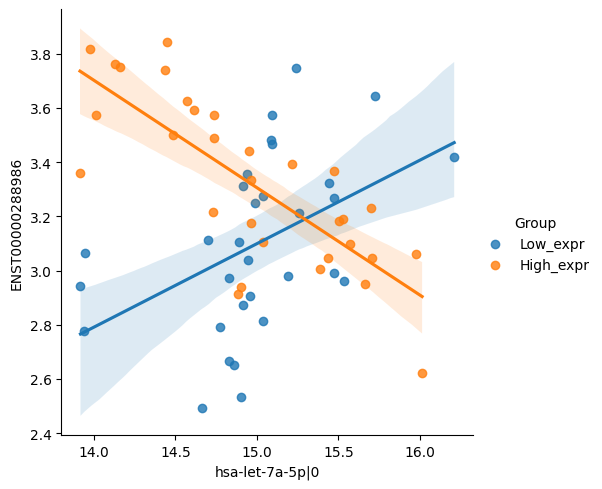

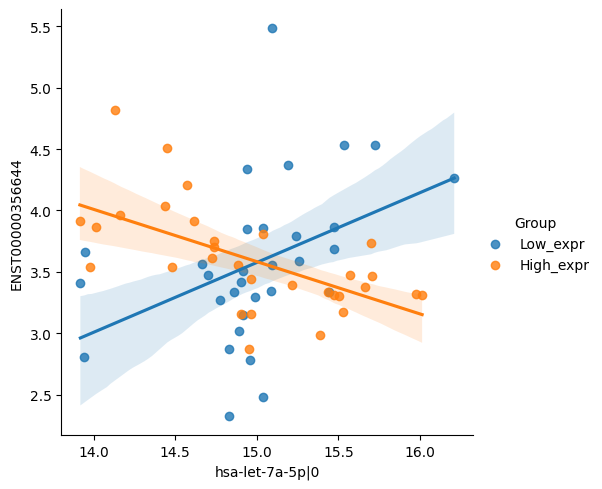

In [59]:
from scipy.stats import spearmanr

def scatter_gene_pairs(ztest_df, row_ind, expr_matrix, annot):
    annot = annot.copy(); expr_matrix = expr_matrix.copy()
    gene1, gene2 = ztest_df.loc[row_ind, ['Source', 'Target']]
    annot[gene1] = expr_matrix.loc[gene1, annot['Sample']].to_numpy()
    annot[gene2] = expr_matrix.loc[gene2, annot['Sample']].to_numpy()
#     ref = expr_matrix.loc[:, annot.loc[annot['Group'] == 'Low_expr']['Sample']]
#     return ref.loc[[gene1, gene2]]
#     return spearmanr(ref.loc[gene1], ref.loc[gene2])
    return sns.lmplot(data=annot, x=gene1, y=gene2, hue="Group")
    
scatter_gene_pairs(rna22_adj_perm, 0, brca_normal_united, descr)
scatter_gene_pairs(rna22_adj_perm, 615, brca_normal_united, descr)
# scatter_gene_pairs(rna22_adj_perm, 2512, brca_rna22_filtered, descr_rna22_filtered)

## То же, но Luminal A

In [62]:
annotation.value_counts()

Sample type  
Luminal A        561
Luminal B        210
Basal-like       183
Normal           104
HER2-enriched     80
Normal-like       39
dtype: int64

In [99]:
luminalA_ids = annotation.loc[annotation['Sample type'] == 'Luminal A'].index.to_numpy()
brca_luminalA_exp_all = dcona_runs.extract_samples(gene_exp, luminalA_ids, additional_columns=['gene symbol'])
brca_luminalA_exp = dcona_runs.filter_by_median(brca_luminalA_exp_all, additional_columns=['gene symbol'], cutoff=95)

In [100]:
brca_luminalA_exp = dcona_runs.remove_transcript_version(brca_luminalA_exp)

In [69]:
brca_luminalA_exp

,gene symbol,TCGA-3C-AAAU-01,TCGA-3C-AALK-01,TCGA-4H-AAAK-01,TCGA-5L-AAT0-01,TCGA-5L-AAT1-01,TCGA-A1-A0SD-01,TCGA-A1-A0SE-01,TCGA-A1-A0SF-01,TCGA-A1-A0SG-01,...,TCGA-S3-AA12-01,TCGA-S3-AA14-01,TCGA-UL-AAZ6-01,TCGA-V7-A7HQ-01,TCGA-W8-A86G-01,TCGA-WT-AB41-01,TCGA-WT-AB44-01,TCGA-XX-A899-01,TCGA-XX-A89A-01,TCGA-Z7-A8R5-01
transcript,,,,,,,,,,,,,,,,,,,,,
ENST00000361624,MT-CO1,12.370556,13.326159,12.012428,12.509315,12.298984,12.753944,12.445883,12.891211,12.371623,...,11.175105,12.503206,14.163905,10.096847,11.754056,11.067674,14.836963,12.372524,12.892694,12.674066
ENST00000362079,MT-CO3,11.598418,13.215642,11.954815,12.628270,12.395132,12.015054,11.969454,12.876686,11.836315,...,10.759775,12.292413,14.090185,11.618968,12.761527,11.830071,15.267028,11.859412,12.561819,13.354857
ENST00000361739,MT-CO2,12.009864,13.157305,11.311868,11.914063,11.784125,11.674504,11.470455,12.080579,11.440191,...,12.169728,12.411250,14.499521,10.669946,12.391939,12.733954,14.405613,11.986532,11.918798,12.999851
ENST00000361899,MT-ATP6,11.158577,12.805992,11.123281,11.851614,11.557834,11.424027,11.879178,11.955851,11.622176,...,11.406084,12.356100,13.344736,10.678872,12.310299,11.985731,14.200162,11.960085,12.186580,12.627044
ENST00000331523,EEF1A1,9.628039,12.639488,11.703556,12.167525,12.184349,10.633584,11.743388,12.307350,11.132635,...,11.449242,11.103150,11.880350,10.558140,12.091816,11.933428,11.723274,11.827391,12.037791,12.857084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENST00000533872,RPS2,1.421856,2.326294,1.741009,1.524404,1.613082,0.397838,0.895235,1.210882,0.924553,...,1.552996,1.266333,3.029040,1.599413,2.773632,1.080478,2.575320,1.784626,2.027825,2.594901
ENST00000504128,GNB2L1,0.642972,1.443112,0.804587,1.777576,1.364866,1.380043,1.200582,1.532927,1.007615,...,1.062304,0.497595,2.659326,2.965678,1.617226,3.766206,4.311611,1.387934,2.011790,3.341186
ENST00000496259,KRBA1,1.243143,1.590724,1.522122,1.642603,1.568932,1.368446,1.252419,1.624048,1.342264,...,1.593575,0.595919,1.679447,0.508465,1.836280,1.274429,0.716293,1.321509,2.010444,1.436960


### Делим по экспрессии AGO2

(0.423, 0.97]     29
(0.97, 1.149]     28
(1.149, 1.22]     28
(1.22, 1.303]     28
(1.303, 1.362]    28
(1.362, 1.416]    28
(1.416, 1.479]    28
(1.479, 1.534]    28
(1.534, 1.572]    28
(1.572, 1.627]    28
(1.627, 1.691]    28
(1.691, 1.754]    28
(1.754, 1.815]    28
(1.815, 1.89]     28
(1.89, 1.972]     28
(1.972, 2.061]    28
(2.061, 2.185]    28
(2.185, 2.307]    28
(2.307, 2.548]    28
(2.548, 4.272]    28
Name: ENST00000220592, dtype: int64


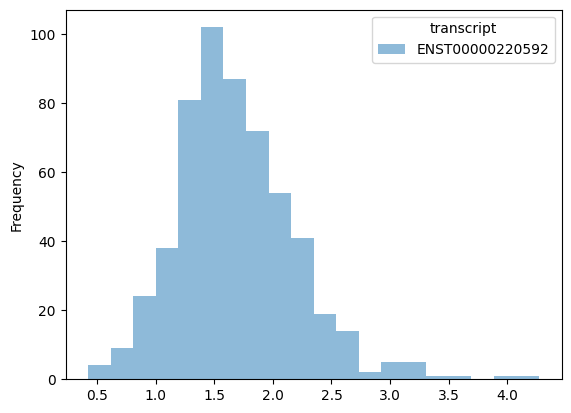

In [85]:
cutter = dcona_runs.CuttingSamples(brca_luminalA_exp, extra_columns=['gene symbol'])
cutter.cut('ENST00000220592', q=20)

In [86]:
cutter.extract_samples(left_num=2, right_num=2)

,Sample,Group
0,TCGA-A1-A0SQ-01,Low_expr
1,TCGA-A2-A0CQ-01,Low_expr
2,TCGA-A2-A0CS-01,Low_expr
3,TCGA-A7-A3RF-01,Low_expr
4,TCGA-A8-A06T-01,Low_expr
...,...,...
108,TCGA-EW-A1PD-01,High_expr
109,TCGA-EW-A2FV-01,High_expr
110,TCGA-GM-A2DA-01,High_expr
111,TCGA-GM-A2DI-01,High_expr


In [87]:
cutter.save_annotation("AGO2_luminalA")

Annotation is saved at: /home/jovyan/shared/narek/outputs/sample_cuts/AGO2_luminalA_ENST00000220592_113_samples.csv


In [88]:
descr_lumA = rc(SHARED_PATH/'narek/outputs/sample_cuts/AGO2_luminalA_ENST00000220592_113_samples.csv')
descr_lumA

,Sample,Group
0,TCGA-A1-A0SQ-01,Low_expr
1,TCGA-A2-A0CQ-01,Low_expr
2,TCGA-A2-A0CS-01,Low_expr
3,TCGA-A7-A3RF-01,Low_expr
4,TCGA-A8-A06T-01,Low_expr
...,...,...
108,TCGA-EW-A1PD-01,High_expr
109,TCGA-EW-A2FV-01,High_expr
110,TCGA-GM-A2DA-01,High_expr
111,TCGA-GM-A2DI-01,High_expr


In [102]:
brca_luminalA_united = pd.concat(tcga_match_samples(brca_luminalA_exp.drop('gene symbol', axis=1), mirna_5prime))
brca_luminalA_united

,TCGA-3C-AAAU-01,TCGA-3C-AALK-01,TCGA-4H-AAAK-01,TCGA-5L-AAT0-01,TCGA-5L-AAT1-01,TCGA-A1-A0SD-01,TCGA-A1-A0SE-01,TCGA-A1-A0SF-01,TCGA-A1-A0SG-01,TCGA-A1-A0SH-01,...,TCGA-S3-AA12-01,TCGA-S3-AA14-01,TCGA-UL-AAZ6-01,TCGA-V7-A7HQ-01,TCGA-W8-A86G-01,TCGA-WT-AB41-01,TCGA-WT-AB44-01,TCGA-XX-A899-01,TCGA-XX-A89A-01,TCGA-Z7-A8R5-01
ENST00000361624,12.370556,13.326159,12.012428,12.509315,12.298984,12.753944,12.445883,12.891211,12.371623,11.666522,...,11.175105,12.503206,14.163905,10.096847,11.754056,11.067674,14.836963,12.372524,12.892694,12.674066
ENST00000362079,11.598418,13.215642,11.954815,12.628270,12.395132,12.015054,11.969454,12.876686,11.836315,11.904826,...,10.759775,12.292413,14.090185,11.618968,12.761527,11.830071,15.267028,11.859412,12.561819,13.354857
ENST00000361739,12.009864,13.157305,11.311868,11.914063,11.784125,11.674504,11.470455,12.080579,11.440191,11.490608,...,12.169728,12.411250,14.499521,10.669946,12.391939,12.733954,14.405613,11.986532,11.918798,12.999851
ENST00000361899,11.158577,12.805992,11.123281,11.851614,11.557834,11.424027,11.879178,11.955851,11.622176,11.898031,...,11.406084,12.356100,13.344736,10.678872,12.310299,11.985731,14.200162,11.960085,12.186580,12.627044
ENST00000331523,9.628039,12.639488,11.703556,12.167525,12.184349,10.633584,11.743388,12.307350,11.132635,11.489624,...,11.449242,11.103150,11.880350,10.558140,12.091816,11.933428,11.723274,11.827391,12.037791,12.857084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hsa-miR-15a-5p|0,6.702110,7.283617,7.503359,7.952153,8.067628,5.687199,6.315989,6.096519,5.882718,5.701426,...,7.688468,7.187468,7.083695,6.286166,6.860289,8.091059,7.709022,7.626403,7.039551,7.034575
hsa-miR-361-3p|0,7.704031,7.431011,6.565150,6.578352,7.721060,7.120807,5.904927,7.097582,6.828461,4.952952,...,6.913671,6.885839,7.478468,6.528228,5.976103,8.446865,6.132603,7.400238,6.781371,6.979489
hsa-miR-629-5p|0,6.708977,6.848383,5.886653,6.613334,7.086306,6.856922,7.071494,6.662727,7.032406,6.653072,...,7.539784,7.012080,5.986333,6.651383,5.743940,6.101493,6.230421,6.518179,6.942974,5.474849
hsa-miR-143-3p|+3,6.236059,4.421904,4.158208,3.994326,4.443685,7.918117,7.337608,6.790173,6.674487,8.127584,...,3.199972,5.023121,2.788948,3.931376,4.718523,4.053430,4.326049,4.622298,4.891635,4.382344


### TargetScan

In [111]:
brca_ts_filtered, descr_ts_filtered, interaction_ts_filtered = dcona_runs.brush_data_before_dcona(brca_luminalA_united, descr_lumA, ts_inter)

In [ ]:
expmt = dcona_runs.Experiment(
    experiment = '2',
    cancer_type = "TCGA-BRCA",
    subtypes = ["Luminal A"],
    interactions_source ='TargetScan'
)

expmt.run_ztest(
    ztest_kwargs = {
        'data_df': brca_ts_filtered, 
        'description_df': descr_ts_filtered, 
        'reference_group': "Low_expr",
        'experimental_group': "High_expr",
        'interaction': interaction_ts_filtered,
        'process_number': 32,
#         'repeats_number': 1000,
    },
    filename='ztest_ts.csv'
)

### RNA22

In [112]:
brca_rna22_filtered, descr_rna22_filtered, interaction_rna22_filtered = dcona_runs.brush_data_before_dcona(brca_luminalA_united, descr_lumA, rna22_inter)

In [ ]:
expmt = dcona_runs.Experiment(
    experiment = '2',
    cancer_type = "TCGA-BRCA",
    subtypes = ["Luminal A"],
    interactions_source ='RNA22'
)

expmt.run_ztest(
    ztest_kwargs = {
        'data_df': brca_rna22_filtered, 
        'description_df': descr_rna22_filtered, 
        'reference_group': "Low_expr",
        'experimental_group': "High_expr",
        'interaction': interaction_rna22_filtered,
        'process_number': 32,
#         'repeats_number': 1000,
    },
    filename='ztest_rna22.csv'
)

### Результаты

In [7]:
ts = rc(OUTPUT_PATH/'experiments/2/ztest_ts.csv')
ts.sort_values('PermutePvalue', inplace=True)

In [9]:
ts = adjust_permute(ts)
ts

,Source,Target,RefCorr,RefPvalue,ExpCorr,ExpPvalue,Statistic,Pvalue,AdjPvalue,PermutePvalue,AdjPermutePvalue
11,hsa-miR-93-5p|+3,ENST00000331495,0.408284,2.206575e-03,-0.572796,0.000011,1.085224,0.000005,0.232565,0.000000,0.000000
18,hsa-miR-93-5p|+3,ENST00000300146,0.639292,4.003818e-07,-0.339918,0.012218,1.110976,0.000003,0.247410,0.000000,0.000000
85,hsa-miR-93-5p|+3,ENST00000361842,0.478416,2.876763e-04,-0.549692,0.000028,1.138868,0.000002,0.345456,0.000000,0.000000
15,hsa-miR-93-5p|+3,ENST00000225388,0.623995,8.738832e-07,-0.295899,0.029742,1.036541,0.000012,0.238420,0.000000,0.000000
73,hsa-miR-93-5p|+3,ENST00000369287,0.525862,5.691794e-05,-0.387355,0.004110,0.993092,0.000027,0.312926,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
455801,hsa-miR-93-5p|+3,ENST00000535577,-0.119264,3.802250e-01,-0.119207,0.384898,-0.000057,0.999807,1.000000,0.999756,1.000013
455800,hsa-miR-10b-5p|0,ENST00000437161,0.123023,3.653517e-01,0.122967,0.370049,0.000057,0.999807,1.000000,0.999763,1.000013
455795,hsa-miR-29c-3p|0,ENST00000382369,0.110448,4.165175e-01,0.110390,0.421114,0.000060,0.999799,1.000000,0.999755,1.000014
455797,hsa-miR-106b-5p|0,ENST00000297268,0.012704,9.256195e-01,0.012645,0.926650,0.000059,0.999802,1.000000,0.999754,1.000015


In [11]:
pvalue_cutoff(ts, 'AdjPermutePvalue')

,Source,Target,RefCorr,RefPvalue,ExpCorr,ExpPvalue,Statistic,Pvalue,AdjPvalue,PermutePvalue,AdjPermutePvalue
11,hsa-miR-93-5p|+3,ENST00000331495,0.408284,2.206575e-03,-0.572796,0.000011,1.085224,0.000005,0.232565,0.000000,0.000000
18,hsa-miR-93-5p|+3,ENST00000300146,0.639292,4.003818e-07,-0.339918,0.012218,1.110976,0.000003,0.247410,0.000000,0.000000
85,hsa-miR-93-5p|+3,ENST00000361842,0.478416,2.876763e-04,-0.549692,0.000028,1.138868,0.000002,0.345456,0.000000,0.000000
15,hsa-miR-93-5p|+3,ENST00000225388,0.623995,8.738832e-07,-0.295899,0.029742,1.036541,0.000012,0.238420,0.000000,0.000000
73,hsa-miR-93-5p|+3,ENST00000369287,0.525862,5.691794e-05,-0.387355,0.004110,0.993092,0.000027,0.312926,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
1345,hsa-miR-1307-3p|0,ENST00000315872,-0.428442,1.277735e-03,0.272454,0.045702,-0.737499,0.001844,0.616282,0.000084,0.049935
1165,hsa-miR-23a-3p|+1,ENST00000336976,0.197369,1.455210e-01,-0.507177,0.000128,0.758915,0.001352,0.599543,0.000083,0.050000
503,hsa-miR-128-3p|0,ENST00000323468,-0.515751,8.189321e-05,0.241900,0.076569,-0.817325,0.000558,0.508538,0.000083,0.050000
1104,hsa-miR-181b-5p|0,ENST00000357002,-0.430062,1.221231e-03,0.282092,0.038442,-0.749926,0.001541,0.597560,0.000083,0.050000


In [12]:
ts['Pvalue'] = ts['PermutePvalue']
ts['AdjPvalue'] = ts['AdjPermutePvalue']

In [19]:
dcona.hypergeom(ts).sort_values('AdjPvalue')

,Molecule,Diff,Total,Proportion,Pvalue,AdjPvalue
0,hsa-miR-93-5p|+3,215,3927,0.054749,0.000000e+00,0.000000e+00
1,hsa-miR-140-3p|+1,51,4703,0.010844,0.000000e+00,0.000000e+00
6,hsa-miR-23a-3p|+1,167,4386,0.038076,0.000000e+00,0.000000e+00
7,hsa-miR-140-3p|0,46,4246,0.010834,0.000000e+00,0.000000e+00
9,hsa-miR-23b-3p|+1,36,4386,0.008208,1.909584e-14,2.100542e-13
13,hsa-miR-22-3p|+1,30,3424,0.008762,5.789813e-13,5.307329e-12
3,hsa-miR-26b-5p|0,24,3864,0.006211,8.175053e-08,6.423256e-07
4,hsa-miR-128-3p|0,21,4445,0.004724,3.180566e-05,2.186639e-04
15,hsa-miR-361-3p|0,19,4180,0.004545,1.216044e-04,7.431377e-04
5,hsa-miR-17-3p|0,19,4762,0.003990,5.959461e-04,3.277703e-03


## Luminal B

In [156]:
reload(dcona_runs)

<module 'dcona_runs' from '/home/jovyan/diploma_scripts/scripts/dcona_runs.py'>

In [130]:
luminalB = dcona_runs.DataProcessor(gene_exp, annotation, mirna)

In [131]:
luminalB.cutoff_expressions(subtypes=['Luminal B'])

21622 genes and 211  samples are chosen


In [134]:
luminalB.cutoff_mirnas()

142 miRNAs are chosen


(0.719, 1.23]     21
(1.23, 1.497]     21
(1.497, 1.7]      21
(1.7, 1.891]      21
(1.891, 2.079]    21
(2.079, 2.234]    21
(2.234, 2.454]    21
(2.454, 2.649]    21
(2.649, 2.836]    21
(2.836, 4.146]    21
Name: ENST00000220592, dtype: int64


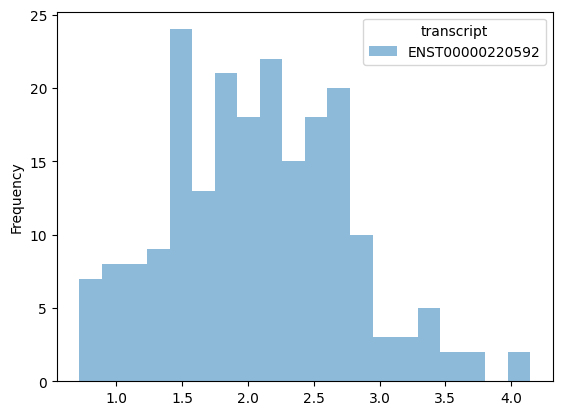

In [139]:
cutter = dcona_runs.CuttingSamples(luminalB.cutted_exp, extra_columns=['gene symbol'])
cutter.cut('ENST00000220592')

In [140]:
cutter.extract_samples(left_num=2, right_num=2)

,Sample,Group
0,TCGA-5T-A9QA-01,Low_expr
1,TCGA-A1-A0SI-01,Low_expr
2,TCGA-A2-A4S3-01,Low_expr
3,TCGA-A7-A13F-01,Low_expr
4,TCGA-A8-A07S-01,Low_expr
...,...,...
79,TCGA-E9-A1R4-01,High_expr
80,TCGA-E9-A226-01,High_expr
81,TCGA-E9-A2JS-01,High_expr
82,TCGA-EW-A6SA-01,High_expr


In [144]:
cutter.save_annotation("AGO2_luminalB")
descr_lumB = rc(SHARED_PATH/'narek/outputs/sample_cuts/AGO2_luminalB_ENST00000220592_84_samples.csv')

File already exists: /home/jovyan/shared/narek/outputs/sample_cuts/AGO2_luminalB_ENST00000220592_84_samples.csv


In [146]:
brca_rna22_filtered, descr_rna22_filtered, interaction_rna22_filtered = luminalB.final_data(descr_lumB, raw_rna22_inter)

In [149]:
interaction_rna22_filtered

,Source,Target
278,hsa-let-7b-5p|0,ENST00000002165
281,hsa-let-7c-5p|0,ENST00000002165
283,hsa-let-7d-3p|0,ENST00000002165
285,hsa-let-7d-5p|0,ENST00000002165
288,hsa-let-7e-5p|0,ENST00000002165
...,...,...
2944786,hsa-miR-379-5p|0,ENST00000633531
2944787,hsa-miR-455-3p|0,ENST00000633531
2944788,hsa-miR-500a-3p|0,ENST00000633531
2944789,hsa-miR-93-5p|0,ENST00000633531


## Basal-like

In [157]:
basal_like = dcona_runs.DataProcessor(gene_exp, annotation, mirna)

In [158]:
basal_like.cutoff_expressions(subtypes=['Basal-like'])

20863 genes and 184 samples are chosen


In [159]:
basal_like.cutoff_mirnas()

142 miRNAs are chosen


(1.2570000000000001, 1.985]    19
(1.985, 2.312]                 18
(2.312, 2.504]                 18
(2.504, 2.667]                 18
(2.667, 2.805]                 19
(2.805, 2.978]                 18
(2.978, 3.283]                 18
(3.283, 3.674]                 18
(3.674, 3.992]                 18
(3.992, 5.529]                 19
Name: ENST00000220592, dtype: int64


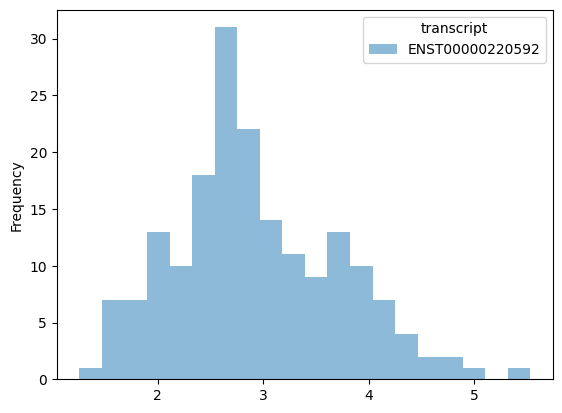

In [167]:
cutter = dcona_runs.CuttingSamples(basal_like.cutted_exp, extra_columns=['gene symbol'])
cutter.cut('ENST00000220592', q=10)

In [168]:
cutter.extract_samples(left_num=2, right_num=2)

,Sample,Group
0,TCGA-A1-A0SO-01,Low_expr
1,TCGA-A2-A04P-01,Low_expr
2,TCGA-A2-A04Q-01,Low_expr
3,TCGA-A2-A4S1-01,Low_expr
4,TCGA-A7-A0CE-01,Low_expr
...,...,...
69,TCGA-E2-A14Y-01,High_expr
70,TCGA-E2-A150-01,High_expr
71,TCGA-E9-A244-01,High_expr
72,TCGA-EW-A1PH-01,High_expr


In [170]:
cutter.save_annotation("AGO2_basalLike")
descr_basalLike = rc(SHARED_PATH/'narek/outputs/sample_cuts/AGO2_basalLike_ENST00000220592_74_samples.csv')

File already exists: /home/jovyan/shared/narek/outputs/sample_cuts/AGO2_basalLike_ENST00000220592_74_samples.csv


In [171]:
brca_rna22_filtered, descr_rna22_filtered, interaction_rna22_filtered = basal_like.final_data(descr_basalLike, raw_rna22_inter)

# DICER1 (ENST00000393063.5)

## Normal

In [36]:
normal = dcona_runs.DataProcessor(gene_exp, annotation, mirna)

In [23]:
normal.cutoff_expressions(subtypes=['Normal'])

23376 genes and 105 samples are chosen


In [24]:
normal.cutoff_mirnas()

142 miRNAs are chosen


(1.885, 2.309]    11
(2.309, 2.387]    10
(2.387, 2.469]    10
(2.469, 2.551]    11
(2.551, 2.619]    10
(2.619, 2.701]    10
(2.701, 2.773]    11
(2.773, 2.87]     10
(2.87, 3.055]     10
(3.055, 3.547]    11
Name: ENST00000393063, dtype: int64


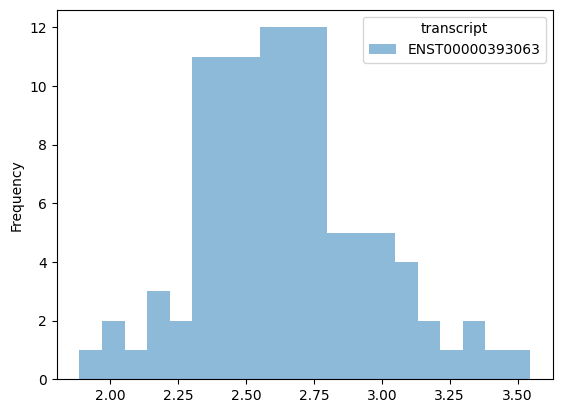

In [25]:
cutter = dcona_runs.CuttingSamples(normal.cutted_exp, extra_columns=['gene symbol'])
cutter.cut('ENST00000393063', q=10)

In [26]:
cutter.extract_samples(left_num=3, right_num=3)

,Sample,Group
0,TCGA-A7-A13E-11,Low_expr
1,TCGA-AC-A2FB-11,Low_expr
2,TCGA-AC-A2FM-11,Low_expr
3,TCGA-BH-A0AY-11,Low_expr
4,TCGA-BH-A0AZ-11,Low_expr
...,...,...
57,TCGA-E9-A1RC-11,High_expr
58,TCGA-E9-A1RD-11,High_expr
59,TCGA-E9-A1RF-11,High_expr
60,TCGA-E9-A1RI-11,High_expr


In [28]:
cutter.save_annotation("DICER1_normal")
descr_normal = rc(SHARED_PATH/'narek/outputs/sample_cuts/DICER1_normal_ENST00000393063_62_samples.csv')

File already exists: /home/jovyan/shared/narek/outputs/sample_cuts/DICER1_normal_ENST00000393063_62_samples.csv


In [31]:
brca_rna22_filtered, descr_rna22_filtered, interaction_rna22_filtered = normal.final_data(descr_normal, raw_rna22_inter)

## Luminal A

In [37]:
lumA = dcona_runs.DataProcessor(gene_exp, annotation, mirna)
lumA.cutoff_expressions(subtypes=['Luminal A'])
lumA.cutoff_mirnas()

22000 genes and 562 samples are chosen
142 miRNAs are chosen


(0.895, 1.475]    19
(1.475, 1.682]    19
(1.682, 1.826]    19
(1.826, 1.931]    18
(1.931, 2.023]    19
(2.023, 2.082]    19
(2.082, 2.145]    18
(2.145, 2.208]    19
(2.208, 2.247]    19
(2.247, 2.297]    18
(2.297, 2.335]    19
(2.335, 2.378]    19
(2.378, 2.428]    18
(2.428, 2.474]    19
(2.474, 2.513]    19
(2.513, 2.56]     18
(2.56, 2.621]     19
(2.621, 2.69]     19
(2.69, 2.745]     18
(2.745, 2.777]    19
(2.777, 2.817]    19
(2.817, 2.851]    18
(2.851, 2.912]    19
(2.912, 2.989]    19
(2.989, 3.052]    18
(3.052, 3.133]    19
(3.133, 3.243]    19
(3.243, 3.433]    18
(3.433, 3.643]    19
(3.643, 4.426]    19
Name: ENST00000393063, dtype: int64


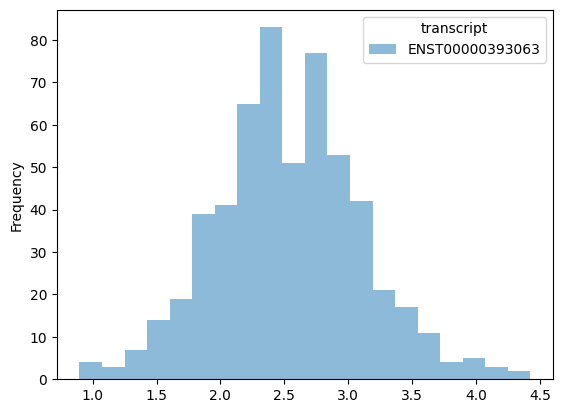

In [43]:
cutter = dcona_runs.CuttingSamples(lumA.cutted_exp, extra_columns=['gene symbol'])
cutter.cut('ENST00000393063', q=30)

In [44]:
cutter.extract_samples(left_num=4, right_num=4)

,Sample,Group
0,TCGA-3C-AAAU-01,Low_expr
1,TCGA-A2-A0CR-01,Low_expr
2,TCGA-A2-A0CS-01,Low_expr
3,TCGA-A2-A0CU-01,Low_expr
4,TCGA-A7-A3J1-01,Low_expr
...,...,...
145,TCGA-GM-A2DM-01,High_expr
146,TCGA-LL-A442-01,High_expr
147,TCGA-OL-A5RX-01,High_expr
148,TCGA-OL-A66H-01,High_expr


In [46]:
cutter.save_annotation("DICER1_luminalA")
descr_normal = rc(SHARED_PATH/'narek/outputs/sample_cuts/DICER1_luminalA_ENST00000393063_150_samples.csv')

File already exists: /home/jovyan/shared/narek/outputs/sample_cuts/DICER1_luminalA_ENST00000393063_150_samples.csv


# DROSHA (ENST00000513349.5)

## Normal

In [47]:
normal = dcona_runs.DataProcessor(gene_exp, annotation, mirna)
normal.cutoff_expressions(subtypes=['Normal'])
normal.cutoff_mirnas()

23376 genes and 105 samples are chosen
142 miRNAs are chosen


(1.284, 2.459]    11
(2.459, 2.606]    10
(2.606, 2.703]    10
(2.703, 2.77]     11
(2.77, 2.804]     10
(2.804, 2.909]    10
(2.909, 2.974]    11
(2.974, 3.055]    10
(3.055, 3.13]     10
(3.13, 3.528]     11
Name: ENST00000513349, dtype: int64


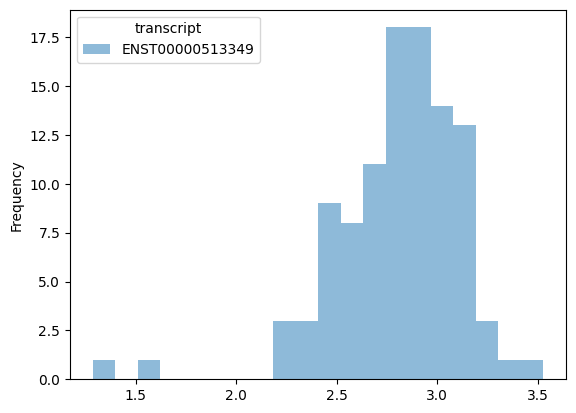

In [49]:
cutter = dcona_runs.CuttingSamples(normal.cutted_exp, extra_columns=['gene symbol'])
cutter.cut('ENST00000513349', q=10)

In [50]:
cutter.extract_samples(left_num=3, right_num=3)

,Sample,Group
0,TCGA-A7-A0CE-11,Low_expr
1,TCGA-A7-A0DC-11,Low_expr
2,TCGA-A7-A13E-11,Low_expr
3,TCGA-A7-A13G-11,Low_expr
4,TCGA-AC-A2FM-11,Low_expr
...,...,...
57,TCGA-E9-A1N5-11,High_expr
58,TCGA-E9-A1RB-11,High_expr
59,TCGA-E9-A1RF-11,High_expr
60,TCGA-GI-A2C8-11,High_expr


In [52]:
cutter.save_annotation("DROSHA_normal")
descr_normal = rc(SHARED_PATH/'narek/outputs/sample_cuts/DROSHA_normal_ENST00000513349_62_samples.csv')

File already exists: /home/jovyan/shared/narek/outputs/sample_cuts/DROSHA_normal_ENST00000513349_62_samples.csv


## Luminal A

In [53]:
lumA = dcona_runs.DataProcessor(gene_exp, annotation, mirna)
lumA.cutoff_expressions(subtypes=['Luminal A'])
lumA.cutoff_mirnas()

22000 genes and 562 samples are chosen
142 miRNAs are chosen


(-0.001, 0.57]    19
(0.57, 1.23]      19
(1.23, 1.692]     19
(1.692, 2.072]    18
(2.072, 2.226]    19
(2.226, 2.387]    19
(2.387, 2.474]    18
(2.474, 2.579]    19
(2.579, 2.625]    19
(2.625, 2.693]    18
(2.693, 2.756]    19
(2.756, 2.816]    19
(2.816, 2.859]    18
(2.859, 2.911]    19
(2.911, 2.931]    19
(2.931, 2.983]    18
(2.983, 3.03]     19
(3.03, 3.065]     19
(3.065, 3.103]    18
(3.103, 3.139]    19
(3.139, 3.174]    19
(3.174, 3.229]    18
(3.229, 3.275]    19
(3.275, 3.32]     19
(3.32, 3.373]     18
(3.373, 3.436]    19
(3.436, 3.531]    19
(3.531, 3.649]    18
(3.649, 3.824]    19
(3.824, 4.575]    19
Name: ENST00000513349, dtype: int64


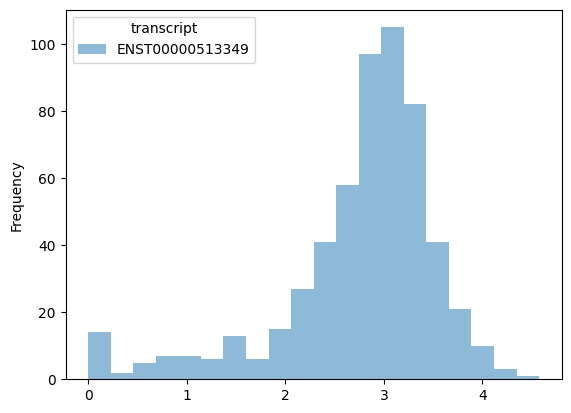

In [54]:
cutter = dcona_runs.CuttingSamples(lumA.cutted_exp, extra_columns=['gene symbol'])
cutter.cut('ENST00000513349', q=30)

In [55]:
cutter.extract_samples(left_num=4, right_num=4)

,Sample,Group
0,TCGA-A2-A04V-01,Low_expr
1,TCGA-A2-A0CK-01,Low_expr
2,TCGA-A2-A0CP-01,Low_expr
3,TCGA-A2-A0CQ-01,Low_expr
4,TCGA-A2-A0CR-01,Low_expr
...,...,...
145,TCGA-E9-A229-01,High_expr
146,TCGA-EW-A1P5-01,High_expr
147,TCGA-EW-A1PD-01,High_expr
148,TCGA-EW-A1PE-01,High_expr


In [57]:
cutter.save_annotation("DROSHA_luminalA")
descr_normal = rc(SHARED_PATH/'narek/outputs/sample_cuts/DROSHA_luminalA_ENST00000513349_150_samples.csv')

File already exists: /home/jovyan/shared/narek/outputs/sample_cuts/DROSHA_luminalA_ENST00000513349_150_samples.csv


# DGCR8 (ENST00000351989.7)

## Normal

In [58]:
normal = dcona_runs.DataProcessor(gene_exp, annotation, mirna)
normal.cutoff_expressions(subtypes=['Normal'])
normal.cutoff_mirnas()

23376 genes and 105 samples are chosen
142 miRNAs are chosen


(1.034, 1.511]    11
(1.511, 1.835]    10
(1.835, 1.975]    10
(1.975, 2.039]    11
(2.039, 2.134]    10
(2.134, 2.208]    10
(2.208, 2.305]    11
(2.305, 2.42]     10
(2.42, 2.522]     10
(2.522, 2.886]    11
Name: ENST00000351989, dtype: int64


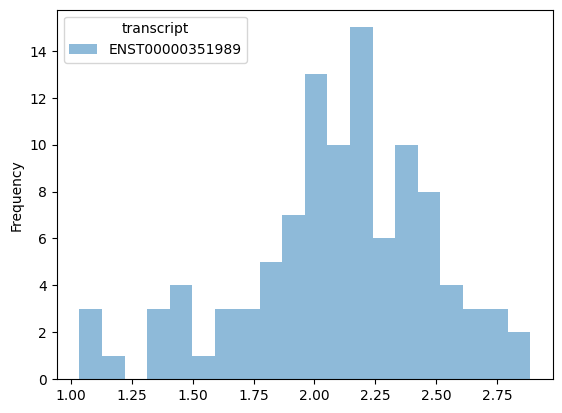

In [59]:
cutter = dcona_runs.CuttingSamples(normal.cutted_exp, extra_columns=['gene symbol'])
cutter.cut('ENST00000351989', q=10)

In [60]:
cutter.extract_samples(left_num=3, right_num=3)

,Sample,Group
0,TCGA-A7-A0DC-11,Low_expr
1,TCGA-A7-A13E-11,Low_expr
2,TCGA-A7-A13G-11,Low_expr
3,TCGA-AC-A2FM-11,Low_expr
4,TCGA-BH-A0DD-11,Low_expr
...,...,...
57,TCGA-E2-A1LH-11,High_expr
58,TCGA-E9-A1N4-11,High_expr
59,TCGA-E9-A1N5-11,High_expr
60,TCGA-GI-A2C8-11,High_expr


In [62]:
cutter.save_annotation("DGCR8_normal")
descr_normal = rc(SHARED_PATH/'narek/outputs/sample_cuts/DGCR8_normal_ENST00000351989_62_samples.csv')

File already exists: /home/jovyan/shared/narek/outputs/sample_cuts/DGCR8_normal_ENST00000351989_62_samples.csv


## Luminal A

In [63]:
lumA = dcona_runs.DataProcessor(gene_exp, annotation, mirna)
lumA.cutoff_expressions(subtypes=['Luminal A'])
lumA.cutoff_mirnas()

22000 genes and 562 samples are chosen
142 miRNAs are chosen


(-0.001, 0.061]    19
(0.061, 0.668]     19
(0.668, 0.867]     19
(0.867, 1.382]     18
(1.382, 1.578]     19
(1.578, 1.701]     19
(1.701, 1.775]     18
(1.775, 1.821]     19
(1.821, 1.902]     19
(1.902, 1.966]     18
(1.966, 2.014]     19
(2.014, 2.051]     19
(2.051, 2.086]     18
(2.086, 2.121]     19
(2.121, 2.171]     19
(2.171, 2.209]     18
(2.209, 2.254]     19
(2.254, 2.29]      19
(2.29, 2.32]       18
(2.32, 2.357]      19
(2.357, 2.377]     19
(2.377, 2.428]     18
(2.428, 2.466]     19
(2.466, 2.507]     19
(2.507, 2.564]     18
(2.564, 2.631]     19
(2.631, 2.684]     19
(2.684, 2.811]     18
(2.811, 2.959]     19
(2.959, 3.767]     19
Name: ENST00000351989, dtype: int64


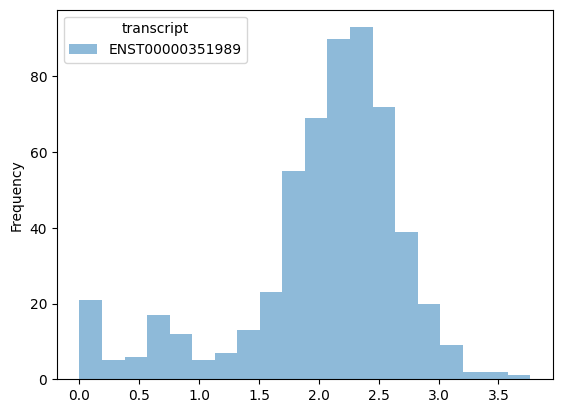

In [65]:
cutter = dcona_runs.CuttingSamples(lumA.cutted_exp, extra_columns=['gene symbol'])
cutter.cut('ENST00000351989', q=30)

In [71]:
cutter.extract_samples(left_num=4, right_num=4)

,Sample,Group
0,TCGA-A2-A04V-01,Low_expr
1,TCGA-A2-A0CP-01,Low_expr
2,TCGA-A2-A0CQ-01,Low_expr
3,TCGA-A2-A0CR-01,Low_expr
4,TCGA-A7-A56D-01,Low_expr
...,...,...
145,TCGA-HN-A2OB-01,High_expr
146,TCGA-LD-A74U-01,High_expr
147,TCGA-LL-A440-01,High_expr
148,TCGA-LL-A740-01,High_expr


In [73]:
cutter.save_annotation("DGCR8_luminalA")
descr_normal = rc(SHARED_PATH/'narek/outputs/sample_cuts/DGCR8_luminalA_ENST00000351989_150_samples.csv')

File already exists: /home/jovyan/shared/narek/outputs/sample_cuts/DGCR8_luminalA_ENST00000351989_150_samples.csv
